## 구글 드라이브를 mount하고 워킹 디렉토리를 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/datasets

/content/drive/MyDrive/datasets


## Testing set 선택 및 전처리

In [3]:
import os
path = os.getcwd() + '/'

Training에 사용된 dataset은 2020년 1학기부터 2022년 1학기까지의 강의평이다.

Testing set은 2019년 2학기의 강의평으로 선택했다.

In [4]:
import pandas as pd
df = pd.read_csv(path + '19-2_dataset.csv')

In [5]:
df.columns = ["index", "year", "type", "subject", "professor", "day", "satisfy", "writer", "ratings0", "ratings1", "ratings2", "ratings3", "comment", "helpful"]
df['ratings2'] = df['ratings2'].astype(int)
df.head(5)

,index,year,type,subject,professor,day,satisfy,writer,ratings0,ratings1,ratings2,ratings3,comment,helpful
0,0,19-2,COSE214,알고리즘(영강),박성빈,#월(6) 수(6),5,자유롭고정의로운진리,3,2,5,4,타과생으로서 정말 최고의 수업이었습니다. 교수님께서 매우 친절하시고 학생들을 생각해...,도움이 돼요 2
1,1,19-2,COSE214,알고리즘(영강),박성빈,#월(6) 수(6),5,kinghonger,4,4,4,3,출석은 가끔하고 과제가 3번? 4번 있습니다 내용이 어렵지만 학점을 잘 주시는 교수님.,도움이 돼요 1
2,2,19-2,COSE214,알고리즘(영강),박성빈,#월(6) 수(6),5,별난거북거북,4,4,3,5,갓성빈 교수님께서 갓성빈하시는 수업입니다. 말이 더 필요하겠습니까. 감사합니다 교수...,도움이 돼요 0
3,3,19-2,COSE214,알고리즘(영강),박성빈,#월(6) 수(6),4,kmkm,3,2,4,2,타 알고리즘 강의에 비해 쉽게 설명하고 시험문제도 쉬운편,도움이 돼요 0
4,4,19-2,COSE214,알고리즘(영강),박성빈,#월(6) 수(6),4,뀩뀨,4,4,5,4,"교수님께서 강의 하시는 거 꼼꼼히 필기하고, 시험 때 교재 참고해서 잘 외우기만 하...",도움이 돼요 0


In [6]:
df = df.drop(columns = ['index', 'year', 'writer', 'comment', 'subject', 'type', 'professor', 'helpful'])
df.head(5)

,day,satisfy,ratings0,ratings1,ratings2,ratings3
0,#월(6) 수(6),5,3,2,5,4
1,#월(6) 수(6),5,4,4,4,3
2,#월(6) 수(6),5,4,4,3,5
3,#월(6) 수(6),4,3,2,4,2
4,#월(6) 수(6),4,4,4,5,4


날짜 및 교시 추출

교시는 모든 수업 날짜 중 가장 빠른 교시를 기준으로 추출함

In [7]:
import re

mon = []
tue = []
wed = []
thu = []
fri = []
period = []
for d in df['day']:
  period.append(min(map(int, re.findall(r'\d', d))))
  mon.append(1 if '월' in d else 0)
  tue.append(1 if '화' in d else 0)
  wed.append(1 if '수' in d else 0)
  thu.append(1 if '목' in d else 0)
  fri.append(1 if '금' in d else 0)

df['mon'] = mon
df['tue'] = tue
df['wed'] = wed
df['thu'] = thu
df['fri'] = fri
df['period'] = period
df = df.drop(columns = ['day'])

In [8]:
df.head(5)

,satisfy,ratings0,ratings1,ratings2,ratings3,mon,tue,wed,thu,fri,period
0,5,3,2,5,4,1,0,1,0,0,6
1,5,4,4,4,3,1,0,1,0,0,6
2,5,4,4,3,5,1,0,1,0,0,6
3,4,3,2,4,2,1,0,1,0,0,6
4,4,4,4,5,4,1,0,1,0,0,6


## Testing

In [9]:
import joblib
loaded_model = joblib.load('clustering.pkl')

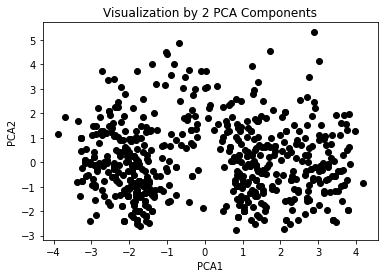

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
df_pca = df.copy()

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df_pca)

df_pca['x'] = pca_transformed[:, 0]
df_pca['y'] = pca_transformed[:, 1]

plt.scatter(x = df_pca['x'], y = df_pca['y'], color = 'k', alpha = 1)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Visualization by 2 PCA Components')
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler

df_kmeans = df_pca.copy()

scaler = MinMaxScaler()
X = scaler.fit_transform(df_kmeans[['x', 'y']])
loaded_model.fit(X)

df['cluster'] = loaded_model.fit_predict(X)
df.head(5)

,satisfy,ratings0,ratings1,ratings2,ratings3,mon,tue,wed,thu,fri,period,cluster
0,5,3,2,5,4,1,0,1,0,0,6,2
1,5,4,4,4,3,1,0,1,0,0,6,2
2,5,4,4,3,5,1,0,1,0,0,6,2
3,4,3,2,4,2,1,0,1,0,0,6,1
4,4,4,4,5,4,1,0,1,0,0,6,2


결과 시각화

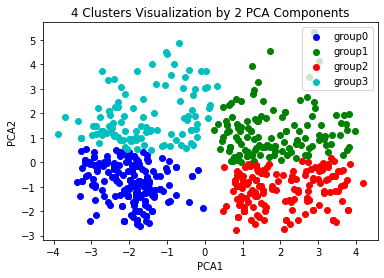

In [12]:
df_pca2 = df.copy()

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df_pca2.drop('cluster', axis=1))

df_pca2['x'] = pca_transformed[:, 0]
df_pca2['y'] = pca_transformed[:, 1]

group0 = df_pca2[df_pca2['cluster'] == 0].index
group1 = df_pca2[df_pca2['cluster'] == 1].index
group2 = df_pca2[df_pca2['cluster'] == 2].index
group3 = df_pca2[df_pca2['cluster'] == 3].index

plt.scatter(x = df_pca2.loc[group0, 'x'], y = df_pca2.loc[group0, 'y'], color = 'b', alpha = 1)
plt.scatter(x = df_pca2.loc[group1, 'x'], y = df_pca2.loc[group1, 'y'], color = 'g', alpha = 1)
plt.scatter(x = df_pca2.loc[group2, 'x'], y = df_pca2.loc[group2, 'y'], color = 'r', alpha = 1)
plt.scatter(x = df_pca2.loc[group3, 'x'], y = df_pca2.loc[group3, 'y'], color = 'c', alpha = 1)


plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('4 Clusters Visualization by 2 PCA Components')
plt.legend(['group0', 'group1', 'group2', 'group3'])
plt.show()

각 Cluster에 해당하는 강의평 수 계산

In [13]:
df.groupby('cluster').count()

,satisfy,ratings0,ratings1,ratings2,ratings3,mon,tue,wed,thu,fri,period
cluster,,,,,,,,,,,
0,203,203,203,203,203,203,203,203,203,203,203
1,133,133,133,133,133,133,133,133,133,133,133
2,159,159,159,159,159,159,159,159,159,159,159
3,107,107,107,107,107,107,107,107,107,107,107


각 Cluster의 center 추출

In [14]:
df.groupby('cluster').mean()

,satisfy,ratings0,ratings1,ratings2,ratings3,mon,tue,wed,thu,fri,period
cluster,,,,,,,,,,,
0,4.152709,4.177340,4.137931,3.487685,4.295567,0.374384,0.650246,0.394089,0.605911,0.0,1.802956
1,3.030075,3.338346,3.180451,3.135338,2.827068,0.548872,0.413534,0.586466,0.413534,0.0,5.488722
2,4.540881,3.798742,3.465409,4.050314,4.251572,0.528302,0.465409,0.534591,0.465409,0.0,5.735849
3,2.457944,3.457944,3.766355,2.560748,2.523364,0.121495,0.644860,0.364486,0.635514,0.0,2.214953
